# Creating the Historical Visualization

In [239]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display

In [240]:
df = pd.read_pickle("data/historical_outbreaks.pkl")

print(type(df))

<class 'pandas.core.frame.DataFrame'>


In [244]:
# A helper function to insert linebreaks into the hover data

def clean_description(d, max_char=30):
    
    # Capitalize first letter
    if d[0].islower():
        upper_char = d[0].upper()
        d = upper_char + d[1:]
    
    words = d.split()
    lines = ''
    current_line = ''
    
    for word in words:
        if len(current_line) + len(word) < max_char:
            current_line += word + ' '
        else:
            current_line += word + '<br>'
            lines += current_line
            current_line = ''
    
    if current_line:
        lines += current_line
            
    return lines
        
# Apply the function

df['Text'] = df['Description'].apply(clean_description) 

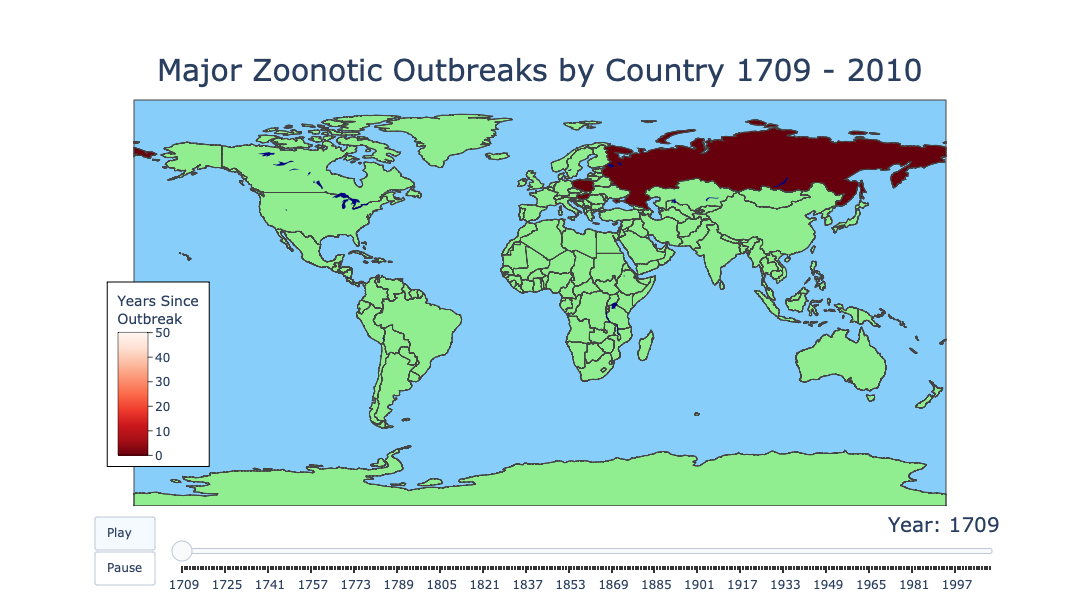

In [264]:
# Extract unique years
years = df['Year'].unique()

# Create a template for hover data
hover_temp = 'Country: %{customdata[0]}<br>\
Outbreak Year: %{customdata[1]}<br>\
Years Since Outbreak: %{customdata[2]}<br><br>\
Description: %{customdata[3]}\
<extra></extra>'
            

# Create a list to store frames
frames = []

# Create frames for each year
for year in years:
    filtered_df = df[df['Year'] == year]
    frame = go.Frame(data=[
        go.Choropleth(
            locations=filtered_df['Country'],
            locationmode='ISO-3',
            z=filtered_df['Years_Since_Outbreak'],
            colorscale = px.colors.sequential.Reds_r,
            colorbar_title='Years Since<br>Outbreak',
            customdata = filtered_df[['Country', 'Outbreak_Year', 'Years_Since_Outbreak', 'Text']],
            hovertemplate=hover_temp,
            colorbar = dict(
                bgcolor='white',
                x=.03,
                y=.1,
                xanchor='left',
                yanchor='bottom',
                len=.45,
                bordercolor='black',
                borderwidth=1,    
            ),
            zmin=0,
            zmax=50,
        )
    ],
        name=f'Frame {year}'
    )
    frames.append(frame)

# Create the initial choropleth map
fig = go.Figure(data=[
    go.Choropleth(
        locations=df.loc[df['Year']==df['Year'].min()]['Country'],
        locationmode='ISO-3',
        z=df['Years_Since_Outbreak'],
        colorscale=px.colors.sequential.Reds_r,
        colorbar_title='Years Since<br>Outbreak',
        customdata = df[['Country', 'Outbreak_Year', 'Years_Since_Outbreak', 'Text']],
        hovertemplate=hover_temp,
        colorbar = dict(
                bgcolor='white',
                x=.03,
                y=.1,
                xanchor='left',
                yanchor='bottom',
                len=.45,
                bordercolor='black',
                borderwidth=1,
                outlinewidth=.5,
                outlinecolor='black',
                nticks=10,
                ticks='outside',
                
            ),
        zmin=0, 
        zmax=50,  
    )
])


# Add frames to the figure
fig.frames = frames

# Select map version
fig.update_geos(
    showcountries=True,
    landcolor='lightgreen',
    showocean=True,
    oceancolor='lightskyblue',
    showlakes=True,
    lakecolor='navy'
)

# Update layout properties
fig.update_layout(
    title_text=f"Major Zoonotic Outbreaks by Country {df['Year'].min()} - {df['Year'].max()}",
    title_font_size=30,
    title_x=.5,
    title_y=.9,
    height=600,
    width=1000,
    
    # Add buttons to interact with
    updatemenus=[{
        'type': 'buttons',
        'x': .08,
        'y': -.025,
        'showactive': True,
        'buttons': [{
            'label': 'Play',
            'method': 'animate',
            'args': [None, {
                'fromcurrent': True,
                'frame': {'duration': 500, 'redraw': True},
                'transition': {'duration': 300, 'easing': 'quadratic-in-out'}
            }]
        }, {
            'label': 'Pause',
            'method': 'animate',
            'args': [[None], {
                'frame': {'duration': 0, 'redraw': True},
                'mode': 'immediate',
                'transition': {'duration': 0}
            }]
        }]
    }],
    
    # Add the year slider
    sliders=[{
        'active': 0,
        'yanchor': 'top',
        'xanchor': 'left',
        'currentvalue': {
            'font': {'size': 20},
            'prefix': 'Year:',
            'visible': True,
            'xanchor': 'right'
        },
        'transition': {'duration': 300, 'easing': 'cubic-in-out'},
        'pad': {'b': 0, 't': 0},
        'len': 0.9,
        'x': 0.1,
        'y': 0.00,
        'steps': [{
            'args': [[f'Frame {year}'], {
                'frame': {'duration': 300, 'redraw': True},
                'mode': 'immediate',
                'transition': {'duration': 300}
            }],
            'label': f' {year}',
            'method': 'animate'
        } for year in years]
    }],
)

# Show the figure
fig.show()